In [1]:
import rockhopper
from rockhopper import VFT

In [2]:
# rockhopper.ui.ingest('/Users/thiele67/Documents/Python/rockhopper/build') # only call this if you rebuild the React app

#### Data preparation

The first step of any new VFT is to gather and preprocess the required data. Normally this includes photographs, photospheres (stored in a single image; if you have photospheres stored in `cube` format see `rockhopper.utils.equirect_to_latlon(...)`) and point clouds.

Point clouds are used for all 3D data format as most 3D objects (textured meshes, volumes, etc.) can be converted to point clouds using software like CloudCompare. `rockhopper` natively supports PLY format point clouds, although you can also use your custome file reader and pass it numpy arrays with shape (points,values), where values is at least x,y,z,r,g,b.

In the following we load an example point cloud (you will probably need to change the path) and create a minimal tour using it.

------


![Screenshot 2025-10-13 at 8.20.25 PM.png](<attachment:Screenshot 2025-10-13 at 8.20.25 PM.png>)

*CloudCompare can be used to convert most 3D data to a point cloud format, and manage the various attributes you want to display.*


----
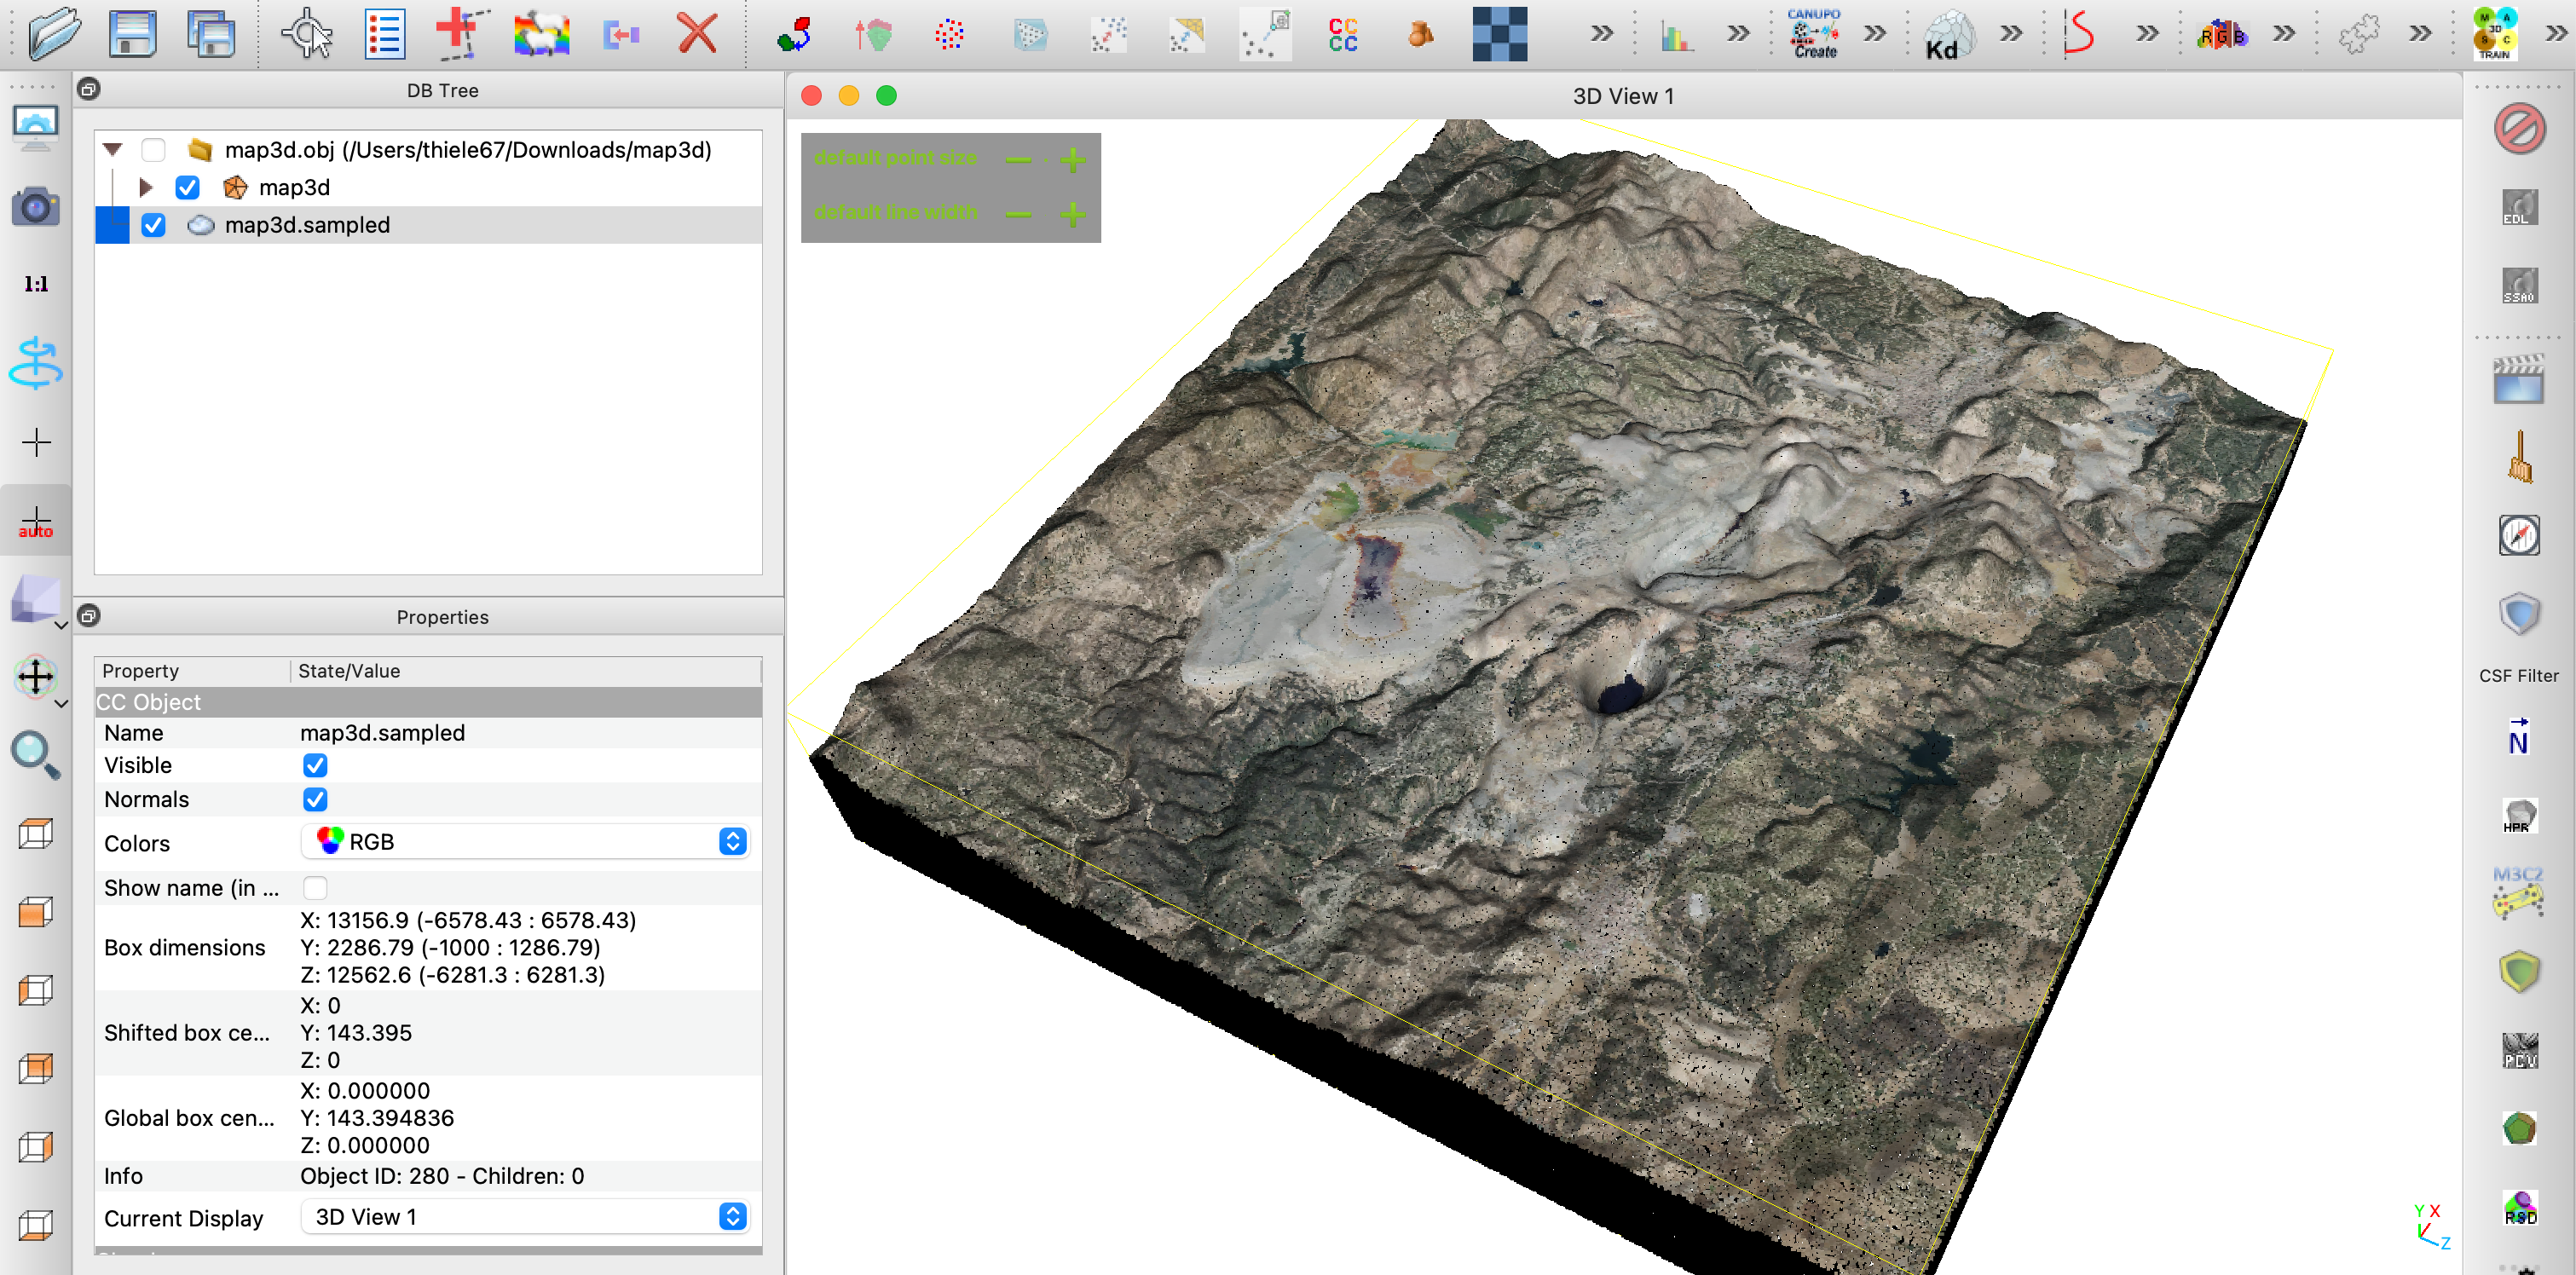

### Creating a tour

Creating a new `rockhopper` tour is quite easy. You simply need to create a new `VFT` object and give it two separate directories:

1. `vft_path` : The file path to the VFT. This is also used as the static folder for the Flask app and will contain all the text (markdown) content, images and other "small" media in your VFT. This directory is kept relatively small so it can e.g., be uploaded to GitHub for version tracking and, if you wish, web-hosting. 

2. `cloud_path` : The directory where the larger 3D point cloud data will be stored. As these can be quite large (especially for tours involving many different clouds) they are kept separate so they can eventually be hosted on some dedicated (static) cloud storage (e.g., Azure or Google Cloud).

Typically when creating a new VFT we also specify the languages it will contain and, potentially, custom "global" tabs (that will be accessible from all of the sites in the VFT).

In [3]:
from rockhopper.server import VFT

# create a new VFT object
vft = VFT( vft_path='../demo/demo_tour', 
           cloud_path='../demo/demo_clouds',
           overwrite=True)

# define the languages the VFT will be translated into (if I were talented enough...)
vft.setLanguages(["en", "es", "de"]) # three languages in this vft
vft.addTab("Index", site=None) # add a global about tab. This will be visible from all sites in the VFT.

The main structure of the tour is stored in the `index.json` file in the `demo_tour` directory. This is also accessible from python via the `vft.index` dictionary. For example, we can see it's content as follows:

In [4]:
vft.index

{'annotURL': './annotations.json',
 'cloudURL': 'https://samthiele.github.io/rockhopper/demo_clouds',
 'languages': ['en', 'es', 'de'],
 'sites': {'annotations': {'labels': {'label1': {'html': '<a href="./#start">Back to Start</a>',
     'pos': [-89.3070683603627, 6.453969682108973, 42.48475772223648]},
    'label10': {'html': 'Double click to delete an annotation',
     'pos': [-90.0616752731552, 35.67709179092396, -20.960379560959208]},
    'label11': {'html': '<a href=\'./#start\'>\n<img src="/icon/hopper_64.png" style="width:32px"/>\n</a>',
     'pos': [-78.86555063047108, 7.067577531112685, 59.661385424993775]},
    'label2': {'html': '<a href="./#annotations">Annotations</a>',
     'pos': [-98.55691455913562, 6.467017509780906, 8.362101712789695]},
    'label3': {'html': '<a href="./#multimedia">To Next Site</a>',
     'pos': [-96.50527228671972, 6.220067832299003, -21.84307072323283]},
    'label4': {'html': '<figure>\n  <img src="https://upload.wikimedia.org/wikipedia/commons/t

We can also edit it and save the changes to disk; though do this with care as it can break the front-end app. In this example, we will specify the order in which the different (global) tabs are displayed:

In [5]:
vft.index['tabs']['_order'] = ['Index', 'Help', 'Notebook', 'References'] # set the order that tabs are displayed in (from left to right)
vft.writeIndex() # save these changes to disk

### Stop 1 -- a photosphere

Next we need to add some media to this tour. In this instance we will create two "sites", one with a 3D point cloud and one with a photosphere. First, the photosphere (as this is easiest).

In [6]:
vft.addPhotosphere(
 site='site1', # site name. Note that this will ALWAYS be converted to lower case for consistency. It defines the URL of this site in the tour.
 image='../demo_data/photosphere.jpg' # path to the photosphere image. This will be copied into the VFT folder structure.
)

Copying photosphere to img/site1/ps.jpg


You will see that this has copied the photosphere image into our VFT directory, ready to be eventually hosted on a public web server.

But, for local development, it is nice to be able to run and interact with our VFT. This is done by spawning a local (Flask) server so we can interact with the VFT through the browser, using `vft.start()`. Click on the link that this creates to see the start of our VFT in action!

## Starting a development server

If you look in the `vft_path` directory you should now see a bunch of files. These are the "web app" that will become our virtual fieldtrip. Important files include:

 - `index.html` : the html file that will become the website our tour is launched through
 - `index.json` : a text (json) file defining the structure of our tour, including all the different sites, tabs, etc. Edit with care!
 - `img/` : a directory containig all the image data in our tour, including the photosphere image for site1. Feel free to add additional images here!

Similarly, the `cloud` directory (or whatever you put for the `cloud_path`) should now have a `Penguin.zarr` directory. This contains all the little chunks of our penguin (poor penguin!) as well as the stylesheet and other attributes (stored in the `.zattrs` file).

To see how this all fits together, we need to spawn a local webserver. This is as easy as `vft.start()`.

In [7]:
vft.start()

Development server started at http://127.0.0.1:4002



While we could build a full VFT exclusively by adding data and editing the `index.json` file, this is slow and tedious. Hence, when a VFT is running locally like this (in "dev" mode), the front-end web app can be used to make changes, add different views ("sites") of the data we have added, and build annotations that help explain your story.

To explain how to use the web app to modify and build a VFT, see the description hosted [here]. Note that you will only be able to use the described functions when running a tour locally, so you should try some of the described features using the new VFT we created and launched above.

Note that we can simeltaneously interact with our VFT through the web app (see link above), and with python. As an example, lets add some more pages to our VFT. These will use the same photosphere, but emphasise different content.

In [ ]:
# add three new "sites" that re-use the same photosphere.
# (these will have the same 3D content but can have different annotations and tabs)
vft.addSite(name='markdown', # the name of the new site
            mediaURL='./img/site1/ps.jpg', # re-use the photosphere created above
            mediaType='photosphere'
            )
vft.addTab(name='Markdown', site='markdown') # add a tab that will appear only at this site

vft.addSite(name='annotations', # the name of the new site
            mediaURL='./img/site1/ps.jpg', # re-use the photosphere created above
            mediaType='photosphere'
            )
vft.addTab(name='Annotations', site='annotations') # add a tab that will appear only at this site

vft.addSite(name='multimedia', # the name of the new site
            mediaURL='./img/site1/ps.jpg', # re-use the photosphere created above
            mediaType='photosphere'
            )
vft.addTab(name='Multimedia', site='multimedia') # add a tab that will appear only at this site

vft.addSite(name='hosting', # the name of the new site
            mediaURL='./img/site1/ps.jpg', # re-use the photosphere created above
            mediaType='photosphere'
            )
vft.addTab(name='Hosting', site='hosting') # add a tab that will appear only at this site

These various sites can be accessed based on their URL, as follows:

- `./#markdown`
- `./#annotations`
- `./#multimedia`

### URLs and "sites'

The first, and most important, thing to understand about `rockhopper` VFTs is that they are built using hyperlinks. Different sites are
defined following the `#` part of the URL, such that `./#site1` will be a URL to "site 1" in our tour, and `./#site2` will be a url to site 2.

Go ahead and change these URLs in the browser to see how this navigation works.

Then, try adding the following to the markdown defining the "Overview" tab, to add links there that allow easy navigation through our tour:

```

## Tour index

- [Site 1: Markdown](./#markdown)
- [Site 2: Annotations](./#annotations)
- [Site 3: Multimedia](./#multimedia)


```

After re-rendering the markdown (Shift+Enter) you should be able to click these links to navigate between the different sites. In this case, the underlying photosphere is the same so not much will change -- but, different Tabs should appear ready to host customised content for each one of these sites.

You can/should also change the default camera position for each site, by clicking the "Save view" button and then clicking "Ok" (more on the popup later -- this can be used to create new sites from the GUI!).

### Annotation and 3D links

It is also possible to add links or other html content into the 3D viewer. To do this, use `Cmd+Left click` to select a point in the model or photosphere (a small yellow sphere should appear) and then press `Enter`. Another popup should open asking you to `Enter label (text or html)`. You can add a label here (e.g., "Cool thing here") and it will be rendered in the 3D viewer. More usefully, you can also put ANY html element here (e.g., images, links, etc. ... though larger elements will be ugly). 

Most useful are 3D links, which can be used to add navigation elements that appear in the 3D viewer. To do this create a new point (as before), press `Enter` and add the following html in the pop-up window:

```
<a href='./#start'>Back to start</a>
```

A shaded black rectangle should then appear, with a link in it that will take you from e.g., the "markdown" page back to the "start".


----

***Exercise:** Add a 3D links that allow us to navigate between the `markdown`, `annotations`, and `multimedia` pages.*

----

### Lines and planes

Annotations can also be more than points; if you `Cmd+Left click` more than once then a 3D polyline will be drawn, which can be useful for highlighting some structures or geometries. If a polyline with exactly 3 vertices is defined then it will be displayed as a best-fit plane (disk), which can be useful for geological structures like bedding.

`Double-click` unwanted annotations to delete them. 

----

***Exercise:** Draw an annotation that outlines the milky way.*

----

### Views and "sites"

If you click the `Save view` button in the web app (lower left of screen), you will notice a pop-up that asks `Enter new site name (or nothing to update current site)`. If you leave this blank (click ok) then it will update the default view position for this scene. Very useful!

If you add a new name, for example `site1b`, it will create an exact copy of the current site that can, for example, host different text or show different annotations (to explaining something different using the same media). As an example, try adding a `site1b` which has different annotation content to `site1a`. If you update your navigation links (or manually navigate using the URL bar in your browser) then you will see these get toggled on and off. Sub-sites like this can also be useful for pre-storing different views at e.g., different locations in an outcrop.

----

***Exercise:** Create different subsites (site1a, site1b, etc) for the photosphere and give these (i) different default views, and (ii) different annotations and labels highlighting different themes (e.g., the geology, the landscape, the vegetation, the unhappy graffiti, etc.).*

----

Now you have all the building blocks of a remarkably sophisticated VFT!

### The `index.json` file

Once you are finished with these changes and updates, have a look at the `index.json` file in your tour directory. This stores all the different sites you made, and it can sometimes be useful to edit it directly. In particular, note how all of the labels, default view and tabs (we'll come to that later) are stored for each site.

### Shutdown

Finally, since we started a web-server, it is important to stop it when we're done (or by restarting the jupyter kernel).

In [9]:
vft.stop()

### Stop 2 -- a point cloud

And now we add stop 2 with the point cloud. This is slightly more complex as we need to create a "symbology" dictionary describing the different options for visualising the point cloud. A key design feature of `rockhopper` is that a single point cloud can have many different colour schemes (e.g., true colour, false colour, elevation, etc.).

These schemes (or colour mappings) are defined as key : value pairs in the a stylesheet dictionary. The key gives the name of the style (which will be displayed in the tour in the top left of the 3D viewer) while the value is another dictionary that define the RGB `colour`of points in the cloud. Two different options are available:

 1. Ternary colour mappings, such as `'color':{'R':(3,0,1), 'G':(4,0,1),'B':(5,0,1)}`
 2. Color ramps, such as `'elev':(2, {'scale':'viridis', 'limits':(-100,100,255)}) }`

A ternary colour mapping is a dict where the keys indicate the `R`,`G`, and `B` channels, and the values give the (`index`, `minimum_value`, `maximum_value`), such that `'R':(3,0,1)` means the red channel will be determined by the `my_cloud[:,3]` data and mapped to be 0 at `minimum_value` and 255 at `maximum_value`.

Color ramps work similarly, except that the tuple has two elements, the first indicating which index of `my_cloud` is taken and the second containing a dictionary defining the color scale to use and its (`minimum_value`, `maximum_value` and `nsteps`). Colour scales can be any valid string indicating a (chroma.js)[https://gka.github.io/chroma.js/] color ramp.

The above is most easily explained using the following example (incidentally the default):

```
stylesheet = {'rgb':{'R':(3,0,1),'G':(4,0,1),'B':(5,0,1)}, # map band 3, 4 and 5 of the cloud array to R, G and B
              'elev':(2, {'scale':'viridis', 'limits':(-100,100,255)}) }` # define colours using a coloramp of index 2 (the z-coordinate)
```

-------

***Important Note**: If numpy arrays are passed to `addCloud` it is assumed that each point is an array of `[x,y,z,r,g,b,attr_1,attr_2,...,attr_n]`. If a path is passed then `loadPLY` is used to parse it and convert to the above numpy array format. Hence why the `rgb` symbology
uses cloud indices 3,4 and 5, and why the `elevation` colour-ramp uses index 2.*

------

In [10]:
# define a style that displays RGB and an additional attribute mapped using a colour ramp
stylesheet = { 'rgb':{'color':{'R':(3,0,1), # satellite RGB 
                               'G':(4,0,1),
                               'B':(5,0,1)}},
               'rainbow':{'color':(1, # map the second channel of the cloud (in this case the y-coordinate) to colour
                                   {'scale':'spectral', 'limits':(-2,2,255)})}, # using this colour ramp and 255 steps
             }

# convert a PLY point cloud to a streamable format and add it to our tour
vft.addCloud( 
  'clouds', # site name. Note that this will ALWAYS be converted to lower case for consistency. It defines the URL of this site in the tour.
  'Penguin', # the name of the zarr file to create (and its URL when hosted elsewhere). Note that these can be re-used.
  '../demo_data/penguin.ply', # the path to our point cloud
   resolution=0.01, # the minimum distance between points (used to downsample clouds and keep filesize down). In this case 1cm.
   stylesheet=stylesheet ) # the colours to use (see above)

Building stream with shape (610451, 7)


In [11]:
vft.addTab(name='Clouds', site='clouds') # add a tab that will appear only at this site

Lets start our development server again so we can see the results.

Be sure to navigate to `./#site2` to see the point cloud.

In [12]:
vft.start()

Development server started at http://127.0.0.1:4002


### Point groups

In additional colour schemes, point clouds can also have point "groups" defined. These either (1) highlight different regions of the point cloud with an emphasis colour, to draw attention to specific features, or (2) toggle the visibility of certain points (to allow e.g., multi-temporal point cloud data).

In the following example, we define a group dictionary that shows how these custom visualisations are defined based on inequalities with respect to some attribute of the point cloud (typically, but not necessarily, a classification scalar field)

In [ ]:
# in addition to the stylesheet, we can pass mask and group elements to add extra visualisation options
groups = {
    "wings" : { # this will add a button that highlights the penguin wings in yellow
        "blend" : 0.3, # the strength of the colour overlay
        "color" : [1,1,0], # the RGB colour to use for the overlay (if activated)
        "iq" : [6, '=', 3] # highlight if the 6th cloud attribute (first scalar field; first six attrs are xyzrgb) is equal to 3
    },
    "legs" : {  # this will add a button that highlights the penguin legs in yellow
        "blend" : 0.3, # the strength of the colour overlay
        "color" : [1,1,0], # the RGB colour to use for the overlay (if activated)
        "iq" : [6, '=', 1] # highlight if the 7th cloud attribute (first scalar field; first six attrs are xyzrgb) is equal to 1
    },
    "body" : { # this will add a button that highlights the penguin body in yellow
        "blend" : 0.3, # the strength of the colour overlay
        "color" : [1,1,0], # the RGB colour to use for the overlay (if activated)
        "iq" : [6, '=', 2] # highlight if the 6th cloud attribute (first scalar field; first six attrs are xyzrgb) is equal to 2
    },
    "skeleton" : { #  this will add a button that hides the penguin body points so that the skeleton is visible
        "mask" : [6, '!=', 0] # mask if the 6th cloud attribute (first scalar field; first six attrs are xyzrgb) is greater than 0
    }
}

# convert a PLY point cloud to a streamable format and add it to our tour
vft.addCloud( 
  'site2', # site name. Note that this will ALWAYS be converted to lower case for consistency. It defines the URL of this site in the tour.
  'Penguin', # the name of the zarr file to create (and its URL when hosted elsewhere). Note that these can be re-used.
  '../demo_data/penguin.ply', # the path to our point cloud
   resolution=0.01, # the minimum distance between points (used to downsample clouds and keep filesize down). In this case 1cm.
   stylesheet=stylesheet, # the colours to use (see above)
   groups=groups, # the groups to allow highlighting and masking (see above)
) 

In [14]:
vft.stop()

# Publishing a VFT

Once a VFT has been constructed in dev-mode, we naturally want to publish it to the web. If you have access to a static web-server then this is very easy -- simply copy the `vft_path` and `cloud_path` directories you chose onto this webserver (both must be publically accessible) and then update the `cloudURL` entry in the `index.json` file to point to your `cloud_path`.

If you don't have your own webserver (unlucky), then the following workflow can be used to (1) upload and server the point cloud data from Google Cloud, and (2) publish your VFT using GitHub pages. For smaller point cloud collections (<500 Mb total) then then everything can be hosted on GitHub.

See [here](https://samthiele.github.io/rockhopper/demo_tour/index.html#/hosting) for more details on how to publish a VFT so that it is publically accessible.

----

***Important note:** Google Cloud has a free trial of several months, after which you will be charged based on how often the clouds you host there are accessed. Unless your VFT becomes a wildly viral hit then these fees will be tiny (a few cents per month).* 

----